# Lab - Collaborative Recommender System

In this lab you will implement the collaborative ﬁltering learning algorithm and apply it to a dataset of movie ratings. 

MovieLens 100k Dataset from GroupLens Research (https://grouplens.org/datasets/movielens/). 

This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u$ = 943 users, and
$n_m$ = 1682 movies. 

In [1]:
#Load relevant libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

  ## Load the data
Load the matrices $Y$ and $R$ from matlab file *ex8_movies.mat*. 
 
$Y$ (*num_movies × num_users*)  stores the ratings $y^{(i,j)}$
(from 1 to 5). 

$R$ is an binary-valued indicator matrix, where $R(i, j)$ = 1 if user $j$ gave a rating to movie $i$, and $R(i, j)$ = 0 otherwise. 

The objective of collaborative ﬁltering is to predict movie ratings for the movies
that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

In [2]:
# Load Y and R

data_source = loadmat("ex8_movies.mat")

Y = data_source["Y"]    # 1682 X 943 matrix, containing ratings (1-5) of 1682 movies on 943 user

R =  data_source["R"]   # 1682 X 943 matrix, R(i,j) = 1 if and only if user j give rating to movie i

# Confirm the shapes of Y and R

print(Y.shape)
print(R.shape)

(1682, 943)
(1682, 943)


In [3]:
# How many users gave a score for the first movie ? ANSWER = 452
num_movies = R.shape[0]
num_users = R.shape[1]


first_movie = R[0,:].reshape(1,num_users)
print(np.sum(first_movie))

# how many users gave a score for the second movie ? ANSWER= 131
second_movie = R[1,:].reshape(1, num_users)
print(np.sum(second_movie))


# How many users gave a score for the last movie ? ANSWER = 1 
last_movie = R[num_movies-1,:].reshape(1, num_users)
print(np.sum(last_movie))

print(np.sum(R, axis=1))


452
131
1
[452 131  90 ...   1   1   1]


In [4]:
#Compute the average movie rating for the ﬁrst movie (Toy Story). ANSWER: 3.88

first_movie = R[0,:].reshape(1,num_users)
first_movie_ratings = Y[0,:].reshape(1, num_users)

average = np.sum(first_movie_ratings)/np.sum(first_movie)
print(average)

3.8783185840707963


### Collaborative Filtering Learning Algorithm

The collaborative ﬁltering algorithm for movie recommendations considers that the movies have features, for example x1=romance, x2=action, x3=comedy, etc. In general the movies have $n$ different features, represented as a set of n-dimensional feature vectors X= $[ x^{(1)},... x^{(n_m)}] $. 

The model that will predict what is the rating $y(i,j)$ for movie $i$ given by user $j$   is formulated as a Linear Regression between the movie features and the user parameters Theta= $[ θ^{(1)}, ...,θ^{(n_u)}] $, that is 

$ y(i,j)=(θ^{(j)})^{T}x^{(i)}$ =>  **Linear Regression model for computing the scores for movie $i$ given by user $j$**

Given a dataset of ratings produced
by **some users on some movies**, the model will try to learn simultaneously both vectors  

 X=$ [x^{(1)},... x^{(n_m)}]$ and Theta=$[θ^{(1)}, ...,θ^{(n_u)}]$
 
 that produce the best ﬁt (minimize the
error between the predictions $y(i,j)$ and the real scores given by the users).


**The collaborative filtering cost function with regularization terms is given by**

$J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}) = \frac{1}{2} \sum_{((i,j): r(i,j)=1)}((\theta^{(j)})^Tx^{(i)} - y^{(i,j)})^2 + (\frac{\lambda}{2} \sum^{n_u}_{j=1}\sum^n_{k=1} (\theta^{(j)}_k)^2) + (\frac{\lambda}{2} \sum^{n_m}_{i=1}\sum^n_{k=1} (x^{(i)}_k)^2)$

**The collaborative filtering gradients of the cost function $J$ (with regularization) are given by**

$\frac{\partial J}{\partial x^{(i)}_k} = \sum ((\theta^{(j)})^Tx^{(i)} - y^{(i,j)})\theta_k^{(j)} +\lambda x^{(i)}_k$

$\frac{\partial J}{\partial \theta^{(j)}_k} = \sum ((\theta^{(j)})^Tx^{(i)} - y^{(i,j)})x_k^{(i)} +\lambda \theta^{(j)}_k$

In [5]:
def  cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    """
    Returns the cost and gradient for the collaborative filtering problem
    
    Lambda - regularization parameter
    
    """
        
    # Unfold the params
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = params[num_movies*num_features:].reshape(num_users,num_features)
    
    predictions =  X @ Theta.T
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)
    
    #compute regularized cost function
    reg_X =  Lambda/2 * np.sum(Theta**2)
    reg_Theta = Lambda/2 *np.sum(X**2)
    reg_J = J + reg_X + reg_Theta
    
    # Compute gradient
    X_grad = err*R @ Theta
    Theta_grad = (err*R).T @ X
    grad = np.append(X_grad.flatten(),Theta_grad.flatten())
    
    # Compute regularized gradient
    reg_X_grad = X_grad + Lambda*X
    reg_Theta_grad = Theta_grad + Lambda*Theta
    reg_grad = np.append(reg_X_grad.flatten(),reg_Theta_grad.flatten())
    
    return J, grad, reg_J, reg_grad

In function *cofiCostFunc*: 
 
$X$ (num_movies × n) is the matrix of movie features (also called movie parameters), $n$ is the number of features,  $i$ row of $X$ corresponds to the feature vector $x^{(i)}$ of the $i$ movie.

$Theta$ (num_users × n) is the matrix of user parameters, $j$ row of $Theta$ corresponds to the parameter vector $θ^{(j)}$, of the $j$ user. 

Both $x^{(i)}$ and $θ^{(j)}$ are n-dimensional vectors, $x^{(i)} ∈ R^{n}$ and $θ^{(j)}∈R^{n}$ .

$X$ and $Theta$ will be inicialized randomly latter on, however, in order to test the *cofiCostFunc* function, we have saved some parameters $X$ and $Theta$ in the matlab file *ex8_movieParams.mat*. 


In [6]:
#Load X and Theta from ex8_movieParams.mat and print their dimensions. 
data_source_2 = loadmat("ex8_movieParams.mat")

X = data_source_2["X"] #  (num_movies X num_features)

Theta = data_source_2["Theta"] #  (num_users X num_features) 

#How many features have the movies ?
print(X.shape)
print(Theta.shape)

(1682, 10)
(943, 10)


In [7]:
# In order to speed up the test, data set size is reduced 
num_users, num_movies, num_features = 4,5,3

#Extract from X, Theta, Y, and R only data coresponding to 
#the new number of users, number of movies, number of features 

X_test = X[:num_movies,:num_features] #(5,3)
Theta_test= Theta[:num_users,:num_features] #(4,3)
Y_test = Y[:num_movies,:num_users] #(5,4)
R_test = R[:num_movies,:num_users] # (5,4)

# Due to the simultaneous optimization of X and Theta, 
#all elements of X and Theta are flattened and appended into a single vector
params = np.append(X_test.flatten(),Theta_test.flatten())

# Compute the cost function (without regularization).  ANSWER: J=22.22
Lambda = 0
print("Cost at loaded parameters (lambda = 0):")
J, grad, reg_J, reg_grad = cofiCostFunc(params, Y_test, R_test, num_users, num_movies, num_features, Lambda)
print(reg_J)

# Compute the cost function (with regularization). ANSWER: J=31.34
Lambda = 1.5
print("Cost at loaded parameters (lambda = 1.5):")
J, grad, reg_J, reg_grad = cofiCostFunc(params, Y_test, R_test, num_users, num_movies, num_features, Lambda)
print(reg_J)

Cost at loaded parameters (lambda = 0):
22.224603725685675
Cost at loaded parameters (lambda = 1.5):
31.34405624427422


### Data set of MOVIES 

The list of all movies and their index in the dataset are listed in the ﬁle *movie_idx.txt*

In [8]:
# load the movie list
#movieList = open("movie_ids.txt","r").read().split("\n")[:-1]

#for Linux users
movieList = open("movie_ids.txt","r", encoding='ISO-8859-1').read().split("\n")[:-1]

#How many movies are collected ?
num_movies= len(movieList)
print(num_movies)

# see the movie list
movieList

1682


['1 Toy Story (1995)',
 '2 GoldenEye (1995)',
 '3 Four Rooms (1995)',
 '4 Get Shorty (1995)',
 '5 Copycat (1995)',
 '6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 '7 Twelve Monkeys (1995)',
 '8 Babe (1995)',
 '9 Dead Man Walking (1995)',
 '10 Richard III (1995)',
 '11 Seven (Se7en) (1995)',
 '12 Usual Suspects, The (1995)',
 '13 Mighty Aphrodite (1995)',
 '14 Postino, Il (1994)',
 "15 Mr. Holland's Opus (1995)",
 '16 French Twist (Gazon maudit) (1995)',
 '17 From Dusk Till Dawn (1996)',
 '18 White Balloon, The (1995)',
 "19 Antonia's Line (1995)",
 '20 Angels and Insects (1995)',
 '21 Muppet Treasure Island (1996)',
 '22 Braveheart (1995)',
 '23 Taxi Driver (1976)',
 '24 Rumble in the Bronx (1995)',
 '25 Birdcage, The (1996)',
 '26 Brothers McMullen, The (1995)',
 '27 Bad Boys (1995)',
 '28 Apollo 13 (1995)',
 '29 Batman Forever (1995)',
 '30 Belle de jour (1967)',
 '31 Crimson Tide (1995)',
 '32 Crumb (1994)',
 '33 Desperado (1995)',
 '34 Doom Generation, The (1995)',
 '35

### Give your own preferences  for some of the movies 
We have ﬁlled out some values according to our own preferences, but you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations!

In [9]:
# Initialize my ratings
my_ratings = np.zeros((num_movies,1))

# Create own ratings
my_ratings[0] = 5
my_ratings[17] = 2
my_ratings[50] = 4
my_ratings[69]= 5
my_ratings[89] = 3
my_ratings[95]= 4
my_ratings[102]= 4
my_ratings[127] = 5
my_ratings[134]= 5
my_ratings[170] = 5
my_ratings[180]= 5

print("New user ratings:\n")
for i in range(len(my_ratings)):
    if my_ratings[i]>0:
        print("Rated",int(my_ratings[i]),"for index",movieList[i])

New user ratings:

Rated 5 for index 1 Toy Story (1995)
Rated 2 for index 18 White Balloon, The (1995)
Rated 4 for index 51 Legends of the Fall (1994)
Rated 5 for index 70 Four Weddings and a Funeral (1994)
Rated 3 for index 90 So I Married an Axe Murderer (1993)
Rated 4 for index 96 Terminator 2: Judgment Day (1991)
Rated 4 for index 103 All Dogs Go to Heaven 2 (1996)
Rated 5 for index 128 Supercop (1992)
Rated 5 for index 135 2001: A Space Odyssey (1968)
Rated 5 for index 171 Delicatessen (1991)
Rated 5 for index 181 Return of the Jedi (1983)


Add the additional ratings in the original dataset Y and R

In [10]:
Y = np.hstack((my_ratings,Y))
R =np.hstack((my_ratings!=0,R))

#Confirm that the number of users increased by one
print(Y.shape[1])
print(R.shape[1])

944
944


### Learning movie recommendations

Normalize the ratings Y. 

Generate random initial values for X and Theta. 

Call Gradient Descent to optimize X and Theta. 

In [11]:
def normalizeRatings(Y, R):
    """
    normalized Y so that each movie has a rating of 0 on average, and returns the 
    mean rating in Ymean.
    """
  
    m = Y.shape[0]
    n= Y.shape[1]
    
    #Inicialize Ymean as column vector of 0 with m elements 
    #Inicialize Ynorm as matrix with the same dimenssion as Y 
    Ymean = np.zeros([m,1])
    Ynorm = Y.copy()
    
    for i in range(m):
        Ymean[i] = np.sum(Y[i,:])/np.count_nonzero(R[i,:])
        Ynorm[i,R[i,:]==1] = Y[i,R[i,:]==1] - Ymean[i]
        
    return Ynorm, Ymean

In [12]:
def gradientDescent(initial_parameters,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
    """
    alpha - learning rate
    Optimize X and Theta
    """
    # unfold the initial parameters (consult function cofiCostFunc)
    X = initial_parameters[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = initial_parameters[num_movies*num_features:].reshape(num_users,num_features)
    
    J_history =[]
    
    for i in range(num_iters):
        #Append into a single vector params X and Theta (see the code above)
        params = np.append(X.flatten(),Theta.flatten())
        cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        # unfold grad
        X_grad = grad[:num_movies*num_features].reshape(num_movies,num_features)
        Theta_grad = grad[num_movies*num_features:].reshape(num_users,num_features)
        
    #Update the trainable parameters X and Theta with the classical gradient descent method
        X = X - alpha*X_grad
        
        Theta = Theta - alpha*Theta_grad
        
        J_history.append(cost)
    
    #Append into a single vector paramsFinal the updated X and Theta
    paramsFinal = np.append(X.flatten(),Theta.flatten())
    return paramsFinal , J_history

In [13]:
# Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

In [14]:
# number of users
num_users = Y.shape[1]

# number of movies
num_movies = Y.shape[0]

num_features = 10

# Generate randomly initial values for the matrices X and Theta 
#(use for example np.random.randn())
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

#Append into a single vector params X and Theta 
initial_parameters = np.append(X.flatten(), Theta.flatten())

Lambda = 10
num_iters=400
alpha=0.001

# Optimize parameters using Gradient Descent, use the normalized Ynorm
paramsFinal, J_history = gradientDescent(initial_parameters, Ynorm, R, num_users, num_movies, num_features,alpha,num_iters,Lambda)

### Plot the cost Function

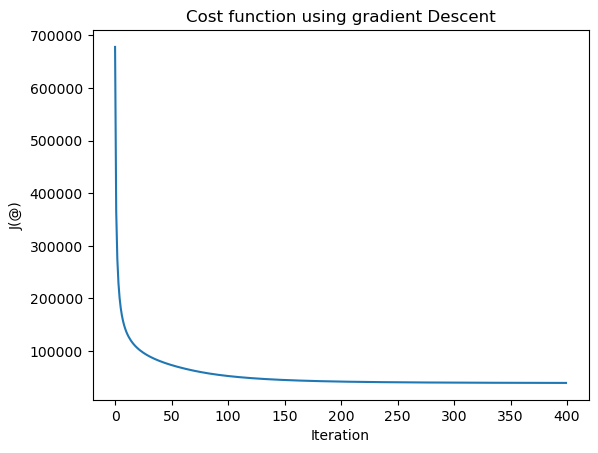

In [15]:
plt.plot(range(len(J_history)), J_history)
plt.xlabel("Iteration")
plt.ylabel("J(@)")
plt.title("Cost function using gradient Descent")
plt.show()


In [16]:
#unfold paramsFinal (consult function cofiCostFunc)
X = paramsFinal[:num_movies*num_features].reshape(num_movies,num_features)
Theta = paramsFinal[num_movies*num_features:].reshape(num_users,num_features)

# Predict all ratings of num_users for num_movies
p = X @ Theta.T

# Extract from p only the recomendations for the added user (the first one)
# Reshape because of rank one problem 

my_scores= p[:,0].reshape([num_movies,1])

my_predictions = my_scores + Ymean

In [17]:
df = pd.DataFrame(np.column_stack((my_predictions,np.array(movieList))))

df.sort_values(by=[0],ascending=False,inplace=True)
df.reset_index(drop=True,inplace=True)

#Extract only the top 10 recommented movies for the added user 
print(df[:10])

                    0                                                  1
0   5.007178370606047                 1599 Someone Else's America (1995)
1    5.00678744158061  1653 Entertaining Angels: The Dorothy Day Stor...
2   5.006297168508531                  814 Great Day in Harlem, A (1994)
3  5.0043422432780496                1122 They Made Me a Criminal (1939)
4   5.001591182301185                               1293 Star Kid (1997)
5   5.000781689423498                            1189 Prefontaine (1997)
6   4.999709268384433                     1500 Santa with Muscles (1996)
7   4.998806506716595          1467 Saint of Fort Washington, The (1993)
8  4.9978179344450355                          1536 Aiqing wansui (1994)
9   4.991771084282593    1201 Marlene Dietrich: Shadow and Light (1996) 


In [19]:
print("Top recommendations for you:\n")
for i in range(10):
    print("Predicting rating ", round(float(df[0][i]),1), " for index ", df[1][i])

Top recommendations for you:

Predicting rating  5.0  for index  1599 Someone Else's America (1995)
Predicting rating  5.0  for index  1653 Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating  5.0  for index  814 Great Day in Harlem, A (1994)
Predicting rating  5.0  for index  1122 They Made Me a Criminal (1939)
Predicting rating  5.0  for index  1293 Star Kid (1997)
Predicting rating  5.0  for index  1189 Prefontaine (1997)
Predicting rating  5.0  for index  1500 Santa with Muscles (1996)
Predicting rating  5.0  for index  1467 Saint of Fort Washington, The (1993)
Predicting rating  5.0  for index  1536 Aiqing wansui (1994)
Predicting rating  5.0  for index  1201 Marlene Dietrich: Shadow and Light (1996) 
